In [1]:
import pandas as pd
import requests
from time import sleep
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from src.core.votacao import TipoVoto
import seaborn as sns
from scipy.stats import ttest_ind_from_stats

In [2]:
projs = pd.read_excel(r"./projetos_selecionados.xlsx")
projs

,tipo,código,ano,tema,ementa,orientação
0,PEC,6,2019,reforma da previdência,"Modifica o sistema de previdência social, esta...",1
1,PL,3418,2021,fundebe,"Altera a Lei nº 14.113, de 25 de dezembro de 2...",1
2,PL,5829,2019,energia renovável,NOVA EMENTA: Institui o marco legal da microge...,1
3,PL,3179,2012,homeschooling,"Altera as Leis nºs 9.394, de 20 de dezembro de...",1


# Dados


In [3]:
df_parls = pd.read_csv("./data/parlamentares.csv")
df_parls["id_parl"] = [str(id_parl) for id_parl in df_parls["id_parl"]]
df_parls=df_parls.drop_duplicates("id_parl")

df_dim_prof = pd.read_excel("./data/dim_profissoes_ficha.xlsx")

df_parls_profs = pd.read_csv("./data/profissoes.csv")

df_profs_d = df_parls_profs[["id_parl", "cod_tipo_profissao", "titulo"]].merge(
    df_dim_prof[["codTipoProfissao", "is_empresario"]],
    left_on="cod_tipo_profissao",
    right_on="codTipoProfissao",
)
df_profs_d = (
    df_profs_d.join(pd.get_dummies(df_profs_d["cod_tipo_profissao"]))
    .groupby("id_parl")
    .max(numeric_only=True)
    .reset_index()
)

df_profs_d["id_parl"] = [str(id_parl) for id_parl in df_profs_d["id_parl"]]

df_parls = df_parls.merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
print(f"Total de parlametares: {len(df_parls)}")

Total de parlametares: 623


In [4]:
df_props = pd.DataFrame()
df_autores = pd.DataFrame()
df_votacoes = pd.DataFrame()
df_votos = pd.DataFrame()
df_orientacoes = pd.DataFrame()

for idx in projs.index:
    nome_tema = projs.loc[idx, "tema "]

    df_tema = pd.read_csv(f"./data/{nome_tema}/projetos.csv")
    df_tema["tema"] = nome_tema
    df_props = pd.concat([df_props, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/autores.csv")
    df_tema["tema"] = nome_tema
    df_autores = pd.concat([df_autores, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/votacoes.csv")
    df_tema["tema"] = nome_tema
    df_votacoes = pd.concat([df_votacoes, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/votos.csv")
    df_tema["tema"] = nome_tema
    df_votos = pd.concat([df_votos, df_tema])

    df_tema = pd.read_csv(f"./data/{nome_tema}/orientacoes.csv").dropna(
        subset="orientacao_voto"
    )
    df_tema["tema"] = nome_tema
    df_orientacoes = pd.concat([df_orientacoes, df_tema])

df_votos["id_parl"] = [str(id_autor) for id_autor in df_votos["id_parl"]]
df_votos = df_votos.drop_duplicates(["id_parl", "id_votacao"])

df_autores["id_autor"] = [str(id_autor) for id_autor in df_autores["id_autor"]]

In [5]:
# df_props.to_excel(f"./data/df_props.xlsx")
# df_autores.to_excel(f"./data/df_autores.xlsx")
# df_votacoes.to_excel(f"./data/df_votacoes.xlsx")
# df_votos.to_excel(f"./data/df_votos.xlsx")
# df_orientacoes.to_excel(f"./data/df_orientacoes.xlsx")
# df_parls.to_excel("./data/df_parls.xlsx")

## Governismo

In [6]:
df_ori_gov = df_orientacoes[
    df_orientacoes["sigla_partido_bloco"] == "Governo"
].reset_index(drop=True)
df_ori_gov["v_trat"] = df_ori_gov["orientacao_voto"].apply(
    lambda x: TipoVoto[x.upper()].value
)

df_v_m_g = df_votos.merge(df_ori_gov, on="id_votacao")
df_v_m_g["ori_g"] = df_v_m_g["voto_trat"] * df_v_m_g["v_trat"]

df_gov = (
    df_v_m_g.join(pd.get_dummies(df_v_m_g["ori_g"]))
    .groupby("id_parl")
    .agg({1: "sum", -1: "sum"})
    .reset_index()
)

df_gov['governismo'] = df_gov[1] / (df_gov[1] + df_gov[-1]) * 100

df_parls_gov = df_parls.merge(df_gov[["id_parl", "governismo"]], on="id_parl")
df_parls_gov = df_parls_gov[
    ["id_parl", "sigla_partido", "sigla_uf", "is_empresario", "governismo"]
].reset_index(drop=True)

# Numeric DF

In [7]:
df_numeric = (
    df_parls_gov.join(pd.get_dummies(df_parls_gov["sigla_uf"], dtype=int, prefix="uf"))
    .join(pd.get_dummies(df_parls_gov["sigla_partido"], dtype=int, prefix="partido"))
    .reset_index(drop=True)
)

df_numeric.drop(
    ["sigla_partido", "sigla_uf"],
    axis=1,
    inplace=True,
)

In [43]:
df_numeric.to_csv('./output/treated/df_parls.csv', index=False)

---


# Descritivas


## Descritivas das variáveis numéricas

In [9]:
df_num_e = df_numeric[df_numeric["is_empresario"] == 1].describe().T
df_num_ne = df_numeric[df_numeric["is_empresario"] == 0].describe().T
df_num_e.join(df_num_ne, lsuffix="_empr", rsuffix="_nao_empr")[
    [
        "mean_empr",
        "std_empr",
        "mean_nao_empr",
        "std_nao_empr",
    ]
]



,mean_empr,std_empr,mean_nao_empr,std_nao_empr
is_empresario,1.000000,0.000000,0.000000,0.000000
governismo,87.116314,19.684664,76.971744,25.815685
uf_AC,0.000000,0.000000,0.024324,0.154263
uf_AL,0.015873,0.125316,0.018919,0.136423
uf_AM,0.010582,0.102595,0.016216,0.126477
uf_AP,0.005291,0.072739,0.021622,0.145642
uf_BA,0.084656,0.279109,0.070270,0.255948
uf_CE,0.058201,0.234745,0.040541,0.197490
uf_DF,0.021164,0.144313,0.013514,0.115616
uf_ES,0.021164,0.144313,0.021622,0.145642


## Empresários por partido

In [10]:
df_empres_by_partido = (
    df_parls.groupby("sigla_partido")
    .agg({"id_parl": "count", "is_empresario": "sum"})
    .rename({"id_parl": "total", "is_empresario": "empresarios"}, axis=1)
    .sort_values("empresarios", ascending=False)
)
df_empres_by_partido["%"] = (
    round(df_empres_by_partido["empresarios"] / df_empres_by_partido["total"] * 100, 1)
)
df_empres_by_partido.loc["Total"] = df_empres_by_partido.sum()
df_empres_by_partido = df_empres_by_partido.astype({'total': 'int32', "empresarios": "int32"})
df_empres_by_partido.to_csv("tabela_empr_partido.csv")
df_empres_by_partido

,total,empresarios,%
sigla_partido,,,
PP,69,34,49.3
PL,85,31,36.5
UNIÃO,64,25,39.1
PSD,58,21,36.2
MDB,43,16,37.2
REPUBLICANOS,55,16,29.1
PT,65,11,16.9
PSC,12,9,75.0
PSDB,32,7,21.9


## Proposições, votações, votações nominais e votos por tema

In [11]:
df_props_tema = df_props.groupby("tema").agg({'id_prop':"count"}).rename({'id_prop': "Proposições"}, axis=1)
df_votacoes_tema = df_votacoes.groupby('tema').agg({'id_votacao': "count"}).rename({'id_votacao': "Votações"}, axis=1)
df_vots_tema = (
    df_votos.groupby(["tema", "id_votacao"])
    .agg({"id_parl": "count"})
    .reset_index()
    .groupby("tema")
    .agg({"id_votacao": "count", "id_parl": "sum"})
    .rename({'id_votacao': "Votações Nominais", "id_parl":"Votos"}, axis=1)
)
df_geral_amostra = df_props_tema.join([df_votacoes_tema, df_vots_tema])
df_geral_amostra

,Proposições,Votações,Votações Nominais,Votos
tema,,,,
energia renovável,101,18,3,1357
fundebe,31,17,4,1589
homeschooling,61,23,12,4055
reforma da previdência,553,383,46,19509


---


# Pareamento


In [38]:
matched_data = pd.read_csv('./output/psm/matched_data.csv', index_col=0)

In [67]:
for tema in df_final['tema'].unique():
    df_pivot = df_final[df_final['tema'] == tema].pivot(columns="id_votacao", index='id_parl', values="voto_trat")
    df_pivot.to_csv(f'./output/treated/df_votos_{tema}.csv')


## calcular rice com matched


In [14]:
def plotar(df_rice):
    ax = sns.boxplot(data=df_rice, x="tema", y="rice", hue="is_empresario")
    ax.set(ylabel="Índice Rice", xlabel="Tema")
    ax.set_xticklabels(["Energia\nRenovável", "FUNDEB","Homeschooling","Reforma da\nPrevidência"])
    labels=["Não Empresário", "Empresário"]
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, labels)
    plt.show()

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.803225  0.183220
                       1                  3  0.808419  0.219908
fundebe                0                  4  0.745984  0.199067
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.656754  0.120036
                       1                 12  0.633763  0.118667
reforma da previdência 0                 46  0.814977  0.175199
                       1                 46  0.756441  0.183270

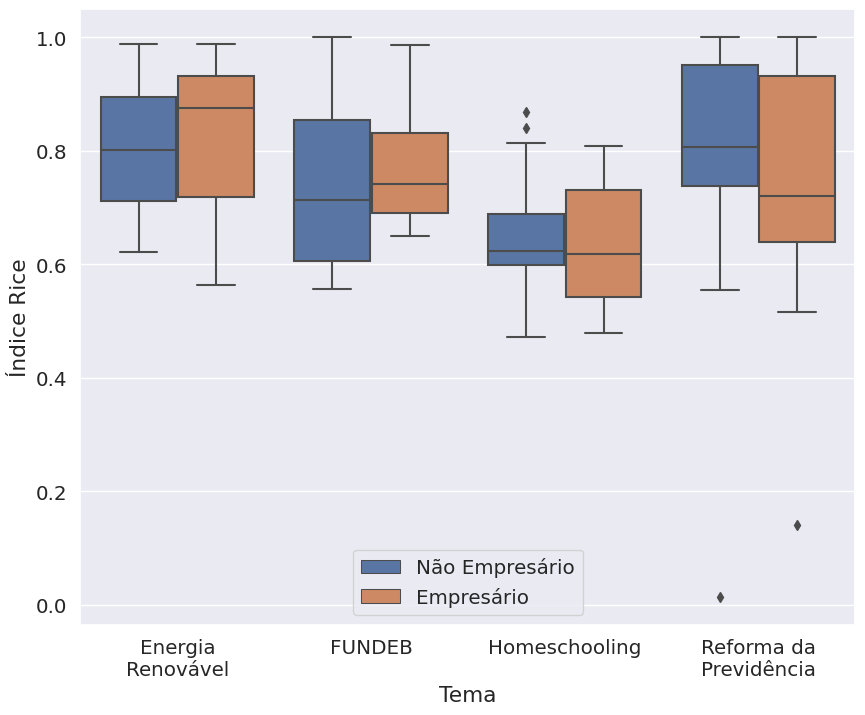

In [15]:
df_final = (
    df_votos[["id_parl", "sigla_partido", "id_votacao", "voto_trat", "tema"]]
    .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .reset_index(drop=True)
)
# calcular rice
df_rice_com = (
    df_final[df_final["id_parl"].isin(matched)]
    .join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice_com["rice"] = abs(df_rice_com[1] - df_rice_com[-1]) / (df_rice_com[1] + df_rice_com[-1])
df_rice_com_g = df_rice_com.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_com_g)
plotar(df_rice_com)

## Rice sem pareamento

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.665049  0.384583
                       1                  3  0.809404  0.218336
fundebe                0                  4  0.657210  0.302955
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.455136  0.251130
                       1                 12  0.633763  0.118667
reforma da previdência 0                 46  0.561660  0.281919
                       1                 46  0.756441  0.183270

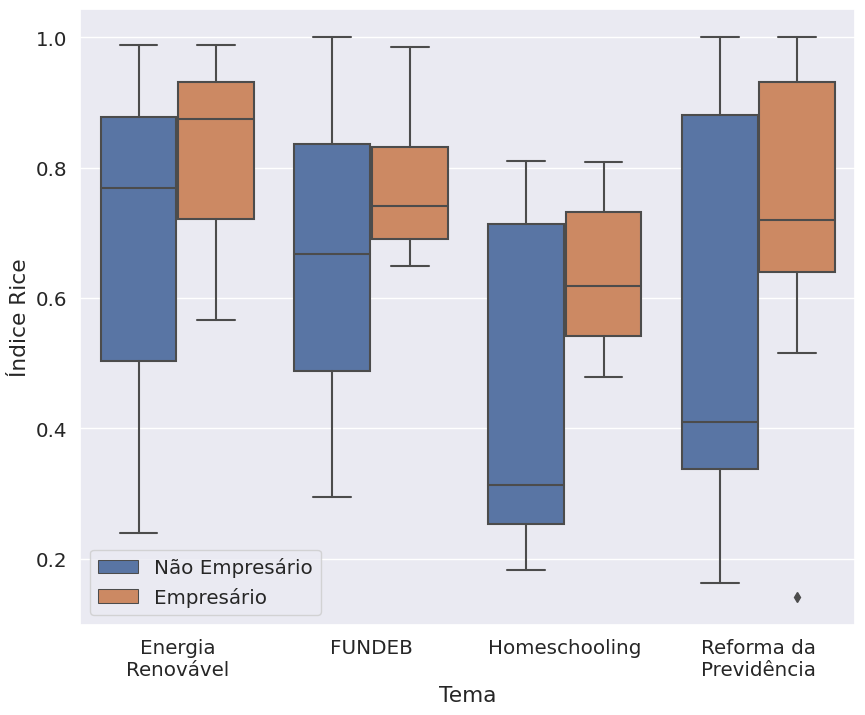

In [16]:
# calcular rice
df_rice_sem= (
    df_final.join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice_sem["rice"] = abs(df_rice_sem[1] - df_rice_sem[-1]) / (df_rice_sem[1] + df_rice_sem[-1])
df_rice_sem_g = df_rice_sem.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_sem_g)
plotar(df_rice_sem)

## testes T

In [17]:
def calcular_stat(df_rice_g):
    df_rice_pivot = df_rice_g.pivot_table(
        columns=["is_empresario"], index="tema", values=["mean", "std", 'count']
    )
    for tema in df_rice_pivot.index:   
        res = ttest_ind_from_stats(
            mean1= df_rice_pivot.loc[tema, ['mean']][0],
            std1= df_rice_pivot.loc[tema, ['std']][0],
            nobs1=df_rice_pivot.loc[tema, ['count']][0],
            mean2= df_rice_pivot.loc[tema, ['mean']][1],
            std2= df_rice_pivot.loc[tema, ['std']][1],
            nobs2=df_rice_pivot.loc[tema, ['count']][1],
        )
        df_rice_pivot.loc[tema, 't_stat'] = res.statistic
        df_rice_pivot.loc[tema, 'pvalue'] = res.pvalue
    return df_rice_pivot

In [18]:
df1 = calcular_stat(df_rice_sem_g)
df2 = calcular_stat(df_rice_com_g)
df_join = df1.join(df2, lsuffix="_sem", rsuffix="_com").round(2)
df_join

count_sem     mean_sem       std_sem       t_stat_sem  \
is_empresario                  0   1        0     1       0     1              
tema                                                                           
energia renovável              3   3     0.67  0.81    0.38  0.22      -0.57   
fundebe                        4   4     0.66  0.78    0.30  0.15      -0.73   
homeschooling                 12  12     0.46  0.63    0.25  0.12      -2.23   
reforma da previdência        46  46     0.56  0.76    0.28  0.18      -3.93   

                       pvalue_sem count_com     mean_com       std_com        \
is_empresario                             0   1        0     1       0     1   
tema                                                                           
energia renovável            0.60         3   3     0.80  0.81    0.18  0.22   
fundebe                      0.50         4   4     0.75  0.78    0.20  0.15   
homeschooling                0.04        12  12     0.66  0.63    0.12  0.12   
reforma da previdência       0.00        46  46     0.81  0.76    0.18  0.18   

                       t_stat_com pvalue_com  
is_empresario                                 
tema                                          
energia renovável           -0.03       0.98  
fundebe                     -0.27       0.80  
homeschooling                0.47       0.64  
reforma da previdência       1.57       0.12

In [19]:
# df_join.to_csv('tstat.csv')

## calcular rice com matching em votações divergentes

In [20]:
df_rice_votacoes = (
    df_votos.join(pd.get_dummies(df_votos["voto_trat"]))
    .groupby("id_votacao")
    .agg({1: "sum", -1: "sum"})
    .reset_index()
)

df_rice_votacoes["rice"] = abs(df_rice_votacoes[1] - df_rice_votacoes[-1]) / (
    df_rice_votacoes[1] + df_rice_votacoes[-1]
)

In [21]:
votacoes_divergentes = list(df_rice_votacoes.query("rice < .95")['id_votacao'])

count      mean       std
tema                   is_empresario                           
energia renovável      0                  3  0.803225  0.183220
                       1                  3  0.808419  0.219908
fundebe                0                  4  0.745984  0.199067
                       1                  4  0.779436  0.147402
homeschooling          0                 12  0.656754  0.120036
                       1                 12  0.633763  0.118667
reforma da previdência 0                 42  0.797706  0.173699
                       1                 42  0.735656  0.178063

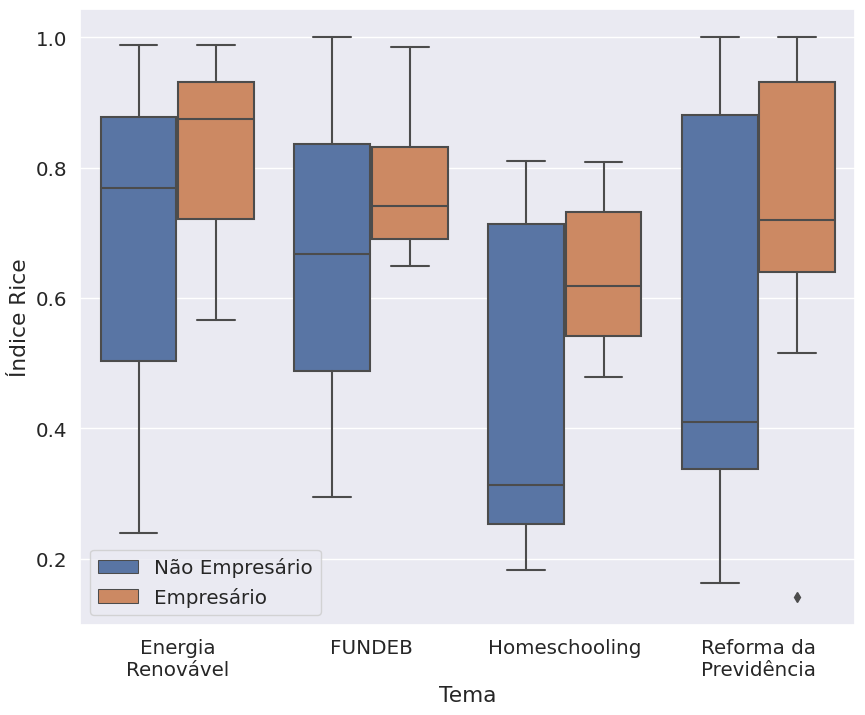

count          mean                 std            \
is_empresario              0   1         0         1         0         1   
tema                                                                       
energia renovável          3   3  0.803225  0.808419  0.183220  0.219908   
fundebe                    4   4  0.745984  0.779436  0.199067  0.147402   
homeschooling             12  12  0.656754  0.633763  0.120036  0.118667   
reforma da previdência    42  42  0.797706  0.735656  0.173699  0.178063   

                          t_stat    pvalue  
is_empresario                               
tema                                        
energia renovável      -0.031427  0.976435  
fundebe                -0.270106  0.796129  
homeschooling           0.471843  0.641685  
reforma da previdência  1.616592  0.109807

In [22]:
df_final = (
    df_votos[df_votos["id_votacao"].isin(votacoes_divergentes)][
        ["id_parl", "sigla_partido", "id_votacao", "voto_trat", "tema"]
    ]
    .merge(df_profs_d[["id_parl", "is_empresario"]], on="id_parl")
    .reset_index(drop=True)
)
# calcular rice
df_rice = (
    df_final[df_final["id_parl"].isin(matched)]
    .join(pd.get_dummies(df_final["voto_trat"]))
    .groupby(["tema", "id_votacao", "is_empresario"])
    .agg(({-1: "sum", 1: "sum"}))
    .reset_index()
)
df_rice["rice"] = abs(df_rice[1] - df_rice[-1]) / (df_rice[1] + df_rice[-1])
df_rice_g = df_rice.groupby(["tema", "is_empresario"])["rice"].agg(["count", "mean", "std"])
display(df_rice_g)
plotar(df_rice_sem)
calcular_stat(df_rice_g)

# W-NOMINATE

In [92]:
df_parls[df_parls['id_parl'] == '115746']

,id_parl,nome,sigla_partido,sigla_uf,is_active,praca,is_empresario
224,115746,Gelson Azevedo,PL,RJ,True,cd,1


In [93]:
name = 'df_wnominate'
df_wnm = pd.read_csv(f'./output/wnominate/{name}.csv', index_col=0)

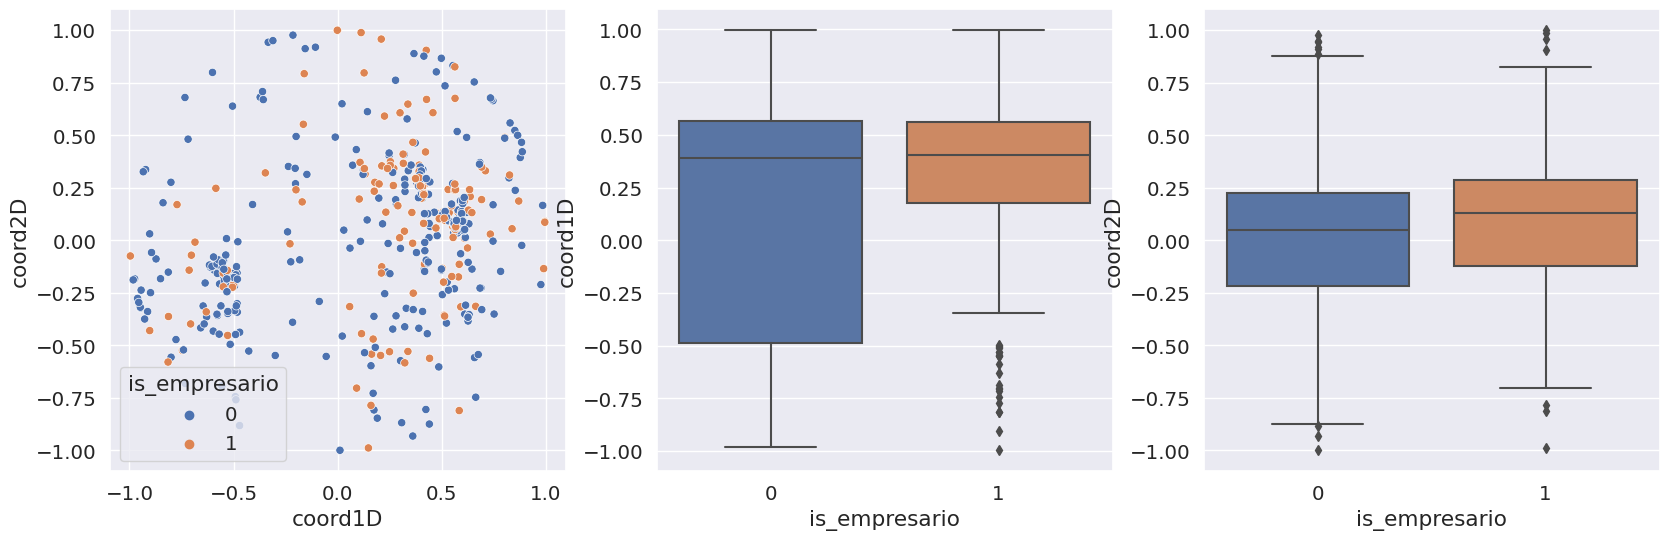

In [94]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 6))
sns.scatterplot(df_wnm, x='coord1D', y='coord2D', hue='is_empresario', ax=axs[0])
sns.boxplot(df_wnm, y="coord1D", x="is_empresario", ax=axs[1])
sns.boxplot(df_wnm, y="coord2D", x="is_empresario", ax=axs[2])
plt.show()